In [1]:
import mujoco
import mediapy as media
from dm_control import mjcf
import numpy as np
from robot_descriptions.panda_mj_description import MJCF_PATH
from scripts.utils import update_actuator, ActuatorMotor

np.random.seed(0)

In [2]:
# load the model
mjcf_model = mjcf.from_path(MJCF_PATH)
# append the body to the end-effector
ee_body = mjcf_model.find("body", "hand")

ee_body

MJCF Element: <body name="hand" pos="0 0 0.107" quat="0.92387949999999996 0 0 -0.38268340000000001">...</body>

In [3]:
# old model
old_model = mujoco.MjModel.from_xml_path(MJCF_PATH)
old_data = mujoco.MjData(old_model)
body_offset = np.where(old_model.body_dofadr == 0)[0][0]

# create new body
load_mass = ee_body.add("body", name="load_mass", pos="0.1 0.05 0.15")
load_mass.add(
    "geom", name="load_mass_geom", type="sphere", size="0.05", rgba="0.8 0.2 0.2 1"
)

M = 2.0
R = 0.1
I = 2 / 5 * M * R**2

load_mass.add("inertial", mass=f"{M}", pos="0.1 0.05 0.15", diaginertia=f"{I} {I} {I}")

physics = mjcf.Physics.from_mjcf_model(mjcf_model)
sim_model = physics.model._model
sim_data = mujoco.MjData(sim_model)
renderer = mujoco.Renderer(sim_model, height=480, width=640)

""

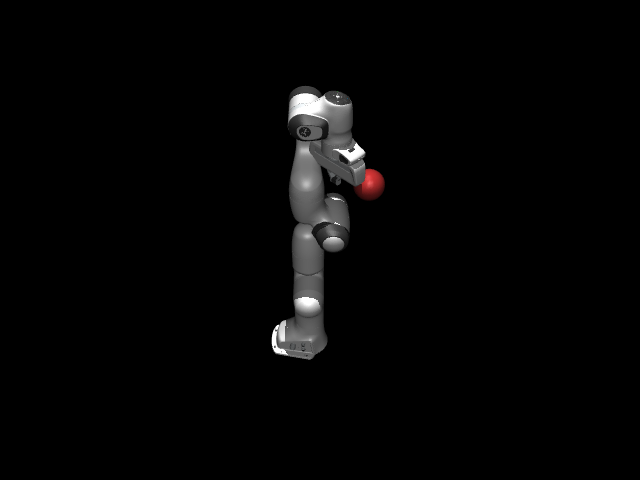

In [4]:
# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)

# Step the simulation.
mujoco.mj_step(sim_model, sim_data)

renderer.update_scene(sim_data)
media.show_image(renderer.render())

In [5]:
def staticload_joint_regressor(mj_model, mj_data, ee_id, active_joints = 7, body_offset = 0):

    accel = np.zeros(6)

    # mujoco.mj_rnePostConstraint(mj_model, mj_data)
    # mujoco.mj_objectAcceleration(mj_model, mj_data, 2, ee_id, accel, 1)
    rotation = mj_data.xmat[ee_id+body_offset].reshape(3, 3).copy()

    a1, a2, a3 = rotation.T @ np.array([0,0,9.81]) #
    static_load_regressor = np.array([[a1, 0, 0, 0],
                                      [a2, 0, 0, 0],
                                      [a3, 0, 0, 0],
                                      [0, 0, a3, -a2],
                                      [0, -a3, 0, a1],
                                      [0, a2, -a1, 0]])
    
    jac_lin = np.zeros((3, mj_model.nv))
    jac_rot = np.zeros((3, mj_model.nv))
    mujoco.mj_jacBody(mj_model, mj_data, jac_lin, jac_rot, ee_id + body_offset)
    ee_local_jacobian = np.vstack((rotation.T@jac_lin[:, :active_joints],
                                   rotation.T@jac_rot[:, :active_joints]))
    joint_regressor = ee_local_jacobian.T @ static_load_regressor
    
    return joint_regressor

In [6]:
for actuator_id in range(sim_model.nu):
    actuator = ActuatorMotor()
    update_actuator(sim_model, actuator_id, actuator)

# find limits except the last two fingers
lower, upper = np.zeros(sim_model.nq - 2), np.zeros(sim_model.nq - 2)
for jnt_idx in range(sim_model.nq - 2):
    lower[jnt_idx] = 0.5*sim_model.joint(jnt_idx).range[0]
    upper[jnt_idx] = 0.5*sim_model.joint(jnt_idx).range[1]

kp = 10
kd = 5
target_q = np.random.uniform(lower, upper)

frames = []
framerate = 25

phase_time = 10.0
num_of_phases = 8
phases = 0
old_data.time = 0 
sim_data.time = 0

# print(sim_model.nq)
load_joint_regressor = np.zeros(((sim_model.nq-2)*num_of_phases, 4))
load_joint_force = np.zeros(((sim_model.nq-2))*num_of_phases)
active_joints = (sim_model.nq-2)

while sim_data.time < num_of_phases*phase_time:
    # PD controller
    mujoco.mj_step(sim_model, sim_data)

    target_acc = kp * (target_q - sim_data.qpos[:-2]) + kd * (
        np.zeros(sim_model.nv - 2) - sim_data.qvel[:-2]
    )

    # use old data to solve inverse dynamics
    old_data.qpos = sim_data.qpos.copy()
    old_data.qvel = sim_data.qvel.copy()
    old_data.qacc[:-2] = target_acc
    mujoco.mj_inverse(old_model, old_data)
    sol = old_data.qfrc_inverse

    sim_data.ctrl[:-1] = sol[:-2]

    if sim_data.time > phase_time * phases and sim_data.time < num_of_phases*phase_time: 
        target_q = np.random.uniform(lower, upper)
        load_force = sol[:7] - old_data.qfrc_bias[:7]
        load_joint_force[7*phases: 7*(phases+1)] = -load_force.copy()
        
        regressor = staticload_joint_regressor(old_model, old_data, old_data.body(ee_body.name).id).copy()
        load_joint_regressor[7*phases: 7*(phases+1), :] = regressor
        phases += 1
        
         
    
    if len(frames) < sim_data.time * framerate:
        renderer.update_scene(sim_data)
        frames.append(renderer.render())
        

media.show_video(frames, fps=framerate)

In [7]:
params_estimates = np.linalg.pinv(load_joint_regressor)@load_joint_force
mass = params_estimates[0]
coordinate = params_estimates[1:]/mass
mass, coordinate

(6.952102957330506, array([3.02246939, 1.58797328, 5.14419372]))

In [8]:
for i in range(len(target_q)):
    print(f"joint {i} target: {target_q[i]:.2f} actual: {sim_data.qpos[i]:.2f}")

joint 0 target: 0.44 actual: 0.40
joint 1 target: -0.43 actual: -0.51
joint 2 target: -0.10 actual: -0.27
joint 3 target: -1.17 actual: -2.03
joint 4 target: -0.99 actual: -0.28
joint 5 target: 0.20 actual: 0.83
joint 6 target: 0.45 actual: 0.20
